<a href="https://colab.research.google.com/github/indahnr/Deep_Learning/blob/main/week_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Concise Implementation of Recurrent Neural Networks

In [27]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, SimpleRNN
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.datasets import mnist


In [28]:
# load mnist dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()


11501568/11490434 [==============================] - 0s 0us/step


In [29]:
# compute the number of labels
num_labels = len(np.unique(y_train))


In [30]:
# convert to one-hot vector
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


In [31]:
# resize and normalize
image_size = x_train.shape[1]
x_train = np.reshape(x_train,[-1, image_size, image_size])
x_test = np.reshape(x_test,[-1, image_size, image_size])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


In [32]:
# network parameters
input_shape = (image_size, image_size)
batch_size = 128
units = 256
dropout = 0.2


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 256)               72960     
                                                                 
 dense_2 (Dense)             (None, 10)                2570      
                                                                 
 activation (Activation)     (None, 10)                0         
                                                                 
Total params: 75,530
Trainable params: 75,530
Non-trainable params: 0
_________________________________________________________________


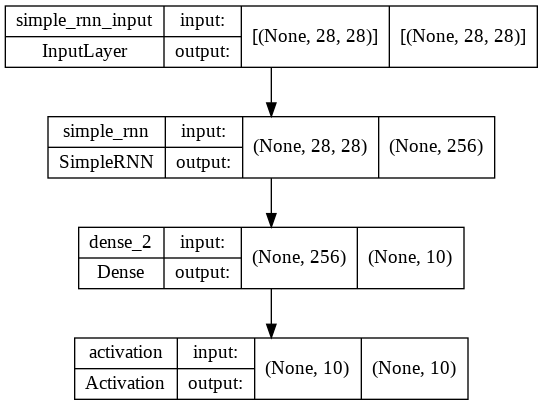

In [33]:
# model is RNN with 256 units, input is 28-dim vector 28 timesteps
model = Sequential()
model.add(SimpleRNN(units=units,
                    dropout=dropout,
                    input_shape=input_shape))
model.add(Dense(num_labels))
model.add(Activation('softmax'))
model.summary()
plot_model(model, to_file='rnn-mnist.png', show_shapes=True)


In [34]:
# loss function for one-hot vector
# use of sgd optimizer
# accuracy is good metric for classification tasks
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
# train the network
model.fit(x_train, y_train, epochs=20, batch_size=batch_size)


Epoch 1/20
469/469 [==============================] - 18s 36ms/step - loss: 0.7493 - accuracy: 0.7847
Epoch 2/20
469/469 [==============================] - 15s 33ms/step - loss: 0.3298 - accuracy: 0.9022
Epoch 3/20
469/469 [==============================] - 17s 37ms/step - loss: 0.2502 - accuracy: 0.9252
Epoch 4/20
469/469 [==============================] - 15s 33ms/step - loss: 0.2069 - accuracy: 0.9378
Epoch 5/20
469/469 [==============================] - 15s 33ms/step - loss: 0.1789 - accuracy: 0.9467
Epoch 6/20
469/469 [==============================] - 15s 33ms/step - loss: 0.1627 - accuracy: 0.9511
Epoch 7/20
469/469 [==============================] - 16s 34ms/step - loss: 0.1448 - accuracy: 0.9559
Epoch 8/20
469/469 [==============================] - 15s 33ms/step - loss: 0.1345 - accuracy: 0.9595
Epoch 9/20
469/469 [==============================] - 16s 33ms/step - loss: 0.1217 - accuracy: 0.9636
Epoch 10/20
469/469 [==============================] - 16s 34ms/step - loss: 0.114

In [35]:
_, acc = model.evaluate(x_test,
                        y_test,
                        batch_size=batch_size,
                        verbose=0)
print("\nTest accuracy: %.1f%%" % (100.0 * acc))



Test accuracy: 98.1%


In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 256)               72960     
                                                                 
 dense_2 (Dense)             (None, 10)                2570      
                                                                 
 activation (Activation)     (None, 10)                0         
                                                                 
Total params: 75,530
Trainable params: 75,530
Non-trainable params: 0
_________________________________________________________________


#RNN d2l

In [46]:
!pip install d2l==0.17.5


In [47]:
import tensorflow as tf
from d2l import tensorflow as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [48]:
num_hiddens = 256
rnn_cell = tf.keras.layers.SimpleRNNCell(num_hiddens,
    kernel_initializer='glorot_uniform')
rnn_layer = tf.keras.layers.RNN(rnn_cell, time_major=True,
    return_sequences=True, return_state=True)

In [49]:
state = rnn_cell.get_initial_state(batch_size=batch_size, dtype=tf.float32)
state.shape

TensorShape([32, 256])

In [50]:
X = tf.random.uniform((num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
Y.shape, len(state_new), state_new[0].shape

(TensorShape([35, 32, 256]), 32, TensorShape([256]))

In [51]:
#save
class RNNModel(tf.keras.layers.Layer):
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs, state):
        X = tf.one_hot(tf.transpose(inputs), self.vocab_size)
        # Later RNN like `tf.keras.layers.LSTMCell` return more than two values
        Y, *state = self.rnn(X, state)
        output = self.dense(tf.reshape(Y, (-1, Y.shape[-1])))
        return output, state

    def begin_state(self, *args, **kwargs):
        return self.rnn.cell.get_initial_state(*args, **kwargs)

In [52]:
device_name = d2l.try_gpu()._device_name
strategy = tf.distribute.OneDeviceStrategy(device_name)
with strategy.scope():
    net = RNNModel(rnn_layer, vocab_size=len(vocab))

d2l.predict_ch8('time traveller', 10, net, vocab)

'time travellerkjgnafrbro'

In [ ]:
num_epochs, lr = 500, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, strategy)